# **NBA Career Prediction**
**Predict 5-Year Career Longevity for NBA Rookies**

## WEEK 3 - Models

In this project, we are trying to classify a rookie player will last at least five years in the NBA or not. This notebook will explore and visualise data and prepare datasets for modelling. The labels are included in the train data, and the goal is to train a model to learn to predict the labels from the features.

Classification: The label is a binary variable, 0 (if career years played < 5), 1 (if career years played >= 5).

Model includes LRs, XGboost, KNN and Ramdom Forest.

**The steps are:**
1. Grid Serch Modeling
    * Import Libraries
    * Load data
2. Start Hyperopt boosting XGboost
3. Best model Prediction

## 1. Grid Search Modeling

##### **[1.1]** Import all modules needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression as LR
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neural_network import MLPClassifier
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings(action="ignore")

##### **[1.2]** Import and prepare datasets

In [31]:
# Get y_train
y_train = pd.read_csv('../data/raw/train.csv')
y_train = y_train.loc[:,'TARGET_5Yrs']
y_train = y_train.reset_index(drop=True)

# Get Feature Engineered Dataset
data = pd.read_csv("../data/processed/final_X_corrs2.csv")
data = data.reset_index(drop=True)

# split train and test set
train = data.iloc[:len(y_train), :]
test = data.iloc[len(y_train):, :]

# fill all np.nan with mode of each column
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train = imputer.fit_transform(train)
X_test = imputer.transform(test)

# Fit and apply the scaling on data and test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=0,
                                                  stratify=y_train)

# Apply RandomOversampling
# Distribution of raw trainset y_train
print('Distribution of raw trainset y_train：{}'.format(Counter(y_train)))

# Distribution of trainset y_ros with oversampling
ros = RandomOverSampler(random_state=0, sampling_strategy='auto')
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print('Distribution of trainset y_ros with oversampling：{}'.format(Counter(y_ros)))

Distribution of raw trainset y_train：Counter({1: 5335, 0: 1065})
Distribution of trainset y_ros with oversampling：Counter({1: 5335, 0: 5335})


Below cell is for reading in Gaussian Mixture clustered dataset, not shown in this version.

In [ ]:
# X_train = np.load('../data/processed/X_train.npy')
# y_train = np.load('../data/processed/y_train.npy')

# X_val   = np.load('../data/processed/X_val.npy')
# y_val  = np.load('../data/processed/y_val.npy')

# X_test  = np.load('../data/processed/X_test.npy')

##### **[1.3]** Define functions

In [3]:
# Models dictionary
models = {"Logistic Regression": LR(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "XGBoost": XGBClassifier()}

#Function that will evaluate the model performance using various metrics
def evaluate_pred(y_pred, y_val):
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    metric_dict = {"accuracy": round(accuracy, 2), "precision": round(precision, 2), "recall": round(recall, 2),
                  "f1": round(f1,2)}
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

# Function that will fit and score the models
def fit_and_score(models, X_train, X_val, y_train, y_val):
    np.random.seed(42)
    
    #Dictionary of model scores
    model_scores = {}
    
    #Loop through models
    for name, model in models.items():
        clf = model
        clf.fit(X_train, y_train)
        model_scores[name] = model.score(X_val, y_val)
    return model_scores

##### **[1.4]** Get default model scores

In [4]:
model_scores = fit_and_score(models, X_train, X_val, y_train, y_val)
model_scores

[19:40:44] WARNING: /private/var/folders/hs/ln67s53n0gxf57pyz_ftzkrw0000gn/T/pip-install-n7uylk98/xgboost_c778489d0ba746e7a2e74a37a7f0c4df/build/temp.macosx-10.9-universal2-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'Logistic Regression': 0.84,
 'KNN': 0.813125,
 'Random Forest': 0.83375,
 'XGBoost': 0.820625}

##### **[1.5]** Define grid search functions

In [5]:
def grid_search_LR_default():
    # Create hyperparameter options, classweight default
    grid={"C":np.logspace(-4, 4, 20), "penalty":["l1","l2"]}

    # Apply grid search
    log_clf = GridSearchCV(LR(max_iter=10000), grid, cv=5, verbose=0, scoring="roc_auc")

    #Fit
    log_clf.fit(X_train, y_train)

    #instantiate the best estimator
    estimator = log_clf.best_estimator_
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_val)
    y_preds_probs=estimator.predict_proba(X_val)[:,1]
    print(estimator)
    print(f'accuracy_val:{accuracy_score(y_pred, y_val)}')
    print(f'auc_val:{roc_auc_score(y_val, y_preds_probs)}')
    print()
    y_pred = estimator.predict(X_train)
    y_preds_probs=estimator.predict_proba(X_train)[:,1]
    print(f'accuracy_train:{accuracy_score(y_pred, y_train)}')
    print(f'auc_train:{roc_auc_score(y_train, y_preds_probs)}')


In [6]:
def grid_search_LR_balanced():
    # Create hyperparameter options, classweight = "balabnced"
    grid={"C":np.logspace(-4, 4, 20), "penalty":["l1","l2"]}

    # Apply grid search
    log_clf = GridSearchCV(LR(max_iter=10000, class_weight='balanced'), grid, cv=5, verbose=0, scoring="roc_auc")

    #Fit
    log_clf.fit(X_train, y_train)
    
    #instantiate the best estimator
    estimator = log_clf.best_estimator_
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_val)
    y_preds_probs=estimator.predict_proba(X_val)[:,1]
    print(estimator)
    print(f'accuracy_val:{accuracy_score(y_pred, y_val)}')
    print(f'auc_val:{roc_auc_score(y_val, y_preds_probs)}')
    print()
    y_pred = estimator.predict(X_train)
    y_preds_probs=estimator.predict_proba(X_train)[:,1]
    print(f'accuracy_train:{accuracy_score(y_pred, y_train)}')
    print(f'auc_train:{roc_auc_score(y_train, y_preds_probs)}')


In [7]:
def grid_search_XGboost():
    #Constructing the grid
    param_test1 = {
     'n_estimators':range(100,300,20),
     'max_depth':range(3,10,2),
     'min_child_weight':range(1,10,2)
    }

    #Apply grid search
    xg_clf = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_test1, cv=5, verbose=0, scoring="roc_auc")
    xg_clf.fit(X_train, y_train)
    
    #instantiate the best estimator
    xg_clf1 = xg_clf.best_estimator_
    xg_clf1.fit(X_train, y_train)
    y_pred = xg_clf1.predict(X_val)
    y_preds_probs = xg_clf1.predict_proba(X_val)[:,1]
    print(xg_clf1)
    print(f'accuracy_val:{accuracy_score(y_pred, y_val)}')
    print(f'auc_val:{roc_auc_score(y_val, y_pred)}, 1&0')
    print(f'auc_val:{roc_auc_score(y_val, y_preds_probs)}, %')
    print()
    y_pred = xg_clf1.predict(X_train)
    y_preds_probs=xg_clf1.predict_proba(X_train)[:,1]
    print(f'accuracy_train:{accuracy_score(y_pred, y_train)}')
    print(f'auc_val:{roc_auc_score(y_train, y_pred)}, 1&0')
    print(f'auc_train:{roc_auc_score(y_train, y_preds_probs)}, %')


In [8]:
def grid_search_KNN():
    #Desired range for k parameter
    k_range = list(range(9, 50))

    #Creating grid
    param_grid = dict(n_neighbors=k_range)

    #Applying GridSearchCV
    knn_clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring="roc_auc")
    knn_clf.fit(X_train, y_train)
    
    #instantiate the best estimator
    knn_clf1 = knn_clf.best_estimator_
    knn_clf1.fit(X_train, y_train)
    y_pred = knn_clf1.predict(X_val)
    y_preds_proba = knn_clf1.predict_proba(X_val)[:,1]
    print(knn_clf1)
    print(f'accuracy_val:{accuracy_score(y_pred, y_val)}')
    print(f'auc_val:{roc_auc_score(y_val, y_pred)}, 1&0')
    print(f'auc_val:{roc_auc_score(y_val, y_preds_proba)}, %')
    y_pred = knn_clf1.predict(X_train)
    y_preds_proba = knn_clf1.predict_proba(X_train)[:,1]
    print()
    print(f'accuracy_train:{accuracy_score(y_pred, y_train)}')
    print(f'auc_train:{roc_auc_score(y_train, y_pred)}, 1&0')
    print(f'auc_train:{roc_auc_score(y_train, y_preds_proba)}, %')


In [9]:
def grid_search_RF():
    #Creating the grid
    param_grid = {
        'n_estimators': range(100,300,20),
        'max_depth': range(3,15,2),
        'random_state': [8888],
        #'max_features': ['auto'],
        #'criterion' :['gini']
    }

    #Applying grid search
    cv_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5, scoring="roc_auc")
    cv_rfc.fit(X_train, y_train)
    
    #instantiate the best estimator
    rfc = cv_rfc.best_estimator_
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_val)
    y_preds_proba = rfc.predict_proba(X_val)[:,1]
    print(rfc)
    print(f'accuracy_val:{accuracy_score(y_pred, y_val)}')
    print(f'auc_val:{roc_auc_score(y_val, y_pred)}, 1&0')
    print(f'auc_val:{roc_auc_score(y_val, y_preds_proba)}, %')
    y_pred = rfc.predict(X_train)
    y_preds_proba = rfc.predict_proba(X_train)[:,1]
    print()
    print(f'accuracy_train:{accuracy_score(y_pred, y_train)}')
    print(f'auc_train:{roc_auc_score(y_train, y_pred)}, 1&0')
    print(f'auc_train:{roc_auc_score(y_train, y_preds_proba)}, %')


In [20]:
def grid_search_NN():
    #Creating the grid
    parameter_space = {
        'hidden_layer_sizes': [(10,30,10),(20,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
    }

    clf = GridSearchCV(MLPClassifier(max_iter=10000), parameter_space, n_jobs=-1, cv=5, scoring="roc_auc")
    clf.fit(X_train, y_train)
    
    #instantiate the best estimator
    nn_clf1 = clf.best_estimator_
    nn_clf1.fit(X_train, y_train)
    y_pred = nn_clf1.predict(X_val)
    y_preds_proba = nn_clf1.predict_proba(X_val)[:,1]
    print(nn_clf1)
    print(f'accuracy_val:{accuracy_score(y_pred, y_val)}')
    print(f'auc_val:{roc_auc_score(y_val, y_pred)}, 1&0')
    print(f'auc_val:{roc_auc_score(y_val, y_preds_proba)}, %')
    y_pred = nn_clf1.predict(X_train)
    y_preds_proba = nn_clf1.predict_proba(X_train)[:,1]
    print()
    print(f'accuracy_train:{accuracy_score(y_pred, y_train)}')
    print(f'auc_train:{roc_auc_score(y_train, y_pred)}, 1&0')
    print(f'auc_train:{roc_auc_score(y_train, y_preds_proba)}, %')

##### **[1.6]** Define start grid search function

In [11]:
def grid_search_start():
    print("LR default:")
    grid_search_LR_default()
    print()
    print("LR balanced:")
    grid_search_LR_balanced()
    print()
    print("XGboost:")
    grid_search_XGboost()
    print()
    print("KNN:")
    grid_search_KNN()
    print()
    print("RF:")
    grid_search_RF()


##### **[1.7]** Get results

In [12]:
print("Data Cleaning: use wk3 result - 90 cols final_X_corrs2")
grid_search_start()

Data Cleaning: use wk3 result - 90 cols final_X_corrs2
LR default:
LogisticRegression(C=0.004832930238571752, max_iter=10000)
accuracy_val:0.83625
auc_val:0.7093539696317255

accuracy_train:0.8346875
auc_train:0.7079982927870252

LR balanced:
LogisticRegression(C=0.0018329807108324356, class_weight='balanced',
                   max_iter=10000)
accuracy_val:0.6625
auc_val:0.708702979337399

accuracy_train:0.643125
auc_train:0.7071186381016497

XGboost:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg

In [21]:
grid_search_NN()

MLPClassifier(activation='tanh', hidden_layer_sizes=(20,), max_iter=10000,
              solver='sgd')
accuracy_val:0.835625
auc_val:0.5116586443620296, 1&0
auc_val:0.6996172966148504, %

accuracy_train:0.8340625
auc_train:0.5126813363781564, 1&0
auc_train:0.705834004338433, %


## 2. Start Hyperopt boosting XGboost

##### **[2.1]** Import all modules needed

In [13]:
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

##### **[2.2]** Define search spaces and functions

In [14]:
# Define search spaces
# wk2:
# space = {
#     'max_depth' : hp.choice('max_depth', range(5, 20, 1)),
#     'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.05),
#     'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
#     'subsample' : hp.quniform('subsample', 0.1, 1, 0.05),
#     'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.05)
# }

#wk3:
space = {
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.05),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    'max_depth':  hp.choice('max_depth', range(2,20,1)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.quniform('subsample', 0.1, 1, 0.05),
    'gamma': hp.quniform('gamma', 0.1, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.05),
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'tree_method': 'exact',
    'silent': 1,
    'seed': 9999
}

In [15]:
# Define objective sunction and self-defined loss function (aimming for higher AUC)
def objective(space):
    from sklearn.model_selection import cross_val_score
    
    xgboost = XGBClassifier(
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        subsample = space['subsample'],
        colsample_bytree = space['colsample_bytree'],
        eval_metric = 'auc',
        eta = space['eta'],
        gamma = space['gamma'],
        n_estimators = int(space['n_estimators']) 
    )
    
    auc = cross_val_score(xgboost, X_train, y_train, cv=10, scoring="roc_auc").mean()

    return{'loss': 1-auc, 'status': STATUS_OK }

##### **[2.3]** Get Hyperopted XGBoost model and predict

In [16]:
# Start hyperboosting 
best = fmin(
    fn=objective,   
    space=space,       
    algo=tpe.suggest,       
    max_evals= 10
)

100%|█████████| 10/10 [06:52<00:00, 41.22s/trial, best loss: 0.3435428029383135]


In [22]:
# Print best model from hyperopt
print("Best: ", best)

Best:  {'colsample_bytree': 0.65, 'eta': 0.325, 'gamma': 0.15000000000000002, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 5.0, 'n_estimators': 374.0, 'subsample': 0.6000000000000001}


In [23]:
# Instantiate best estimator from hyperopt
xgboost2 = XGBClassifier(
    max_depth = best['max_depth'],
    learning_rate = best['learning_rate'],
    min_child_weight = best['min_child_weight'],
    subsample = best['subsample'],
    colsample_bytree = best['colsample_bytree'],
    eval_metric = 'auc',
    eta = best['eta'],
    gamma = best['gamma'],
    n_estimators = int(best['n_estimators'])  
)


# Fit train data
xgboost2.fit(X_train, y_train)

# Predict validation dataset and print accuracy and auc score
y_val_preds = xgboost2.predict(X_val)
y_val_proba = xgboost2.predict_proba(X_val)[:,1]
print(f'accuracy:{accuracy_score(y_val_preds, y_val)}')
print(f'auc:{roc_auc_score(y_val, y_val_preds)}, 1&0')
print(f'auc:{roc_auc_score(y_val, y_val_proba)}, %')
y_train_preds = xgboost2.predict(X_train)
y_train_proba = xgboost2.predict_proba(X_train)[:,1]
print(f'accuracy_train:{accuracy_score(y_train_preds, y_train)}')
print(f'auc_train:{roc_auc_score(y_train, y_train_preds)}, 1&0')
print(f'auc_train:{roc_auc_score(y_train, y_train_proba)}, %')

accuracy:0.823125
auc:0.517706372377721, 1&0
auc:0.6602563379964154, %
accuracy_train:0.96265625
auc_train:0.887793427230047, 1&0
auc_train:0.9995578846399232, %


##### **[2.4]** Compare model scores

**Note:**

Comparing the AUC scores from 4 models using grid search and 1 XGboost model from hyperopt, the best one is default LR, followed by balanced LR then RF.

Select default LR as the wk2 classifier.

We can see the balanced LR model is with a lower accuracy at 0.65, which needs further investigation next week.

Also, the auc for the hyperopted XGboost is suggesting it is overfitted to the train data, which might be resolved next week by reducing the max_evals.

## 3. Best model Prediction

##### **[3.1]** Instantiate best model and predict 

In [24]:
classifier = LR(C=0.004832930238571752, max_iter=10000)
classifier.fit(X_train, y_train)
y_val_preds_probs=classifier.predict_proba(X_val)
y_val_preds = classifier.predict(X_val)

##### **[3.2]** Plot AUC graph

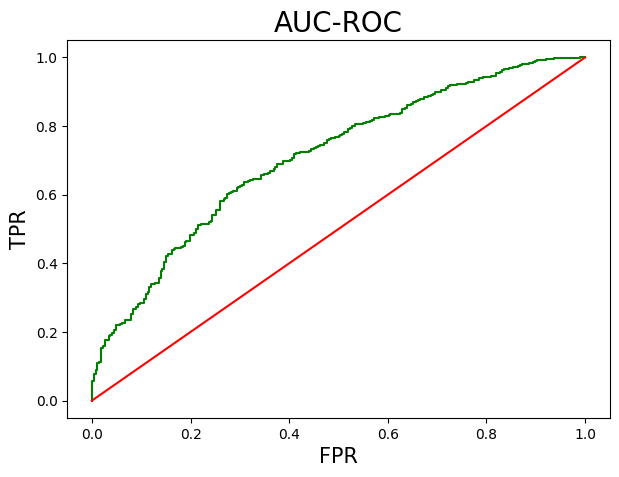

0.7093539696317255

In [25]:
fpr,tpr,threshold=roc_curve(y_val,y_val_preds_probs[:,1])
plt.figure(figsize=(7,5),dpi=100)
plt.plot(fpr,tpr,color='green')
plt.plot([0,1],[0,1],label='baseline',color='red')
plt.xlabel('FPR',fontsize=15)
plt.ylabel('TPR',fontsize=15)
plt.title('AUC-ROC',fontsize=20)
plt.show()
roc_auc_score(y_val,y_val_preds_probs[:,1])

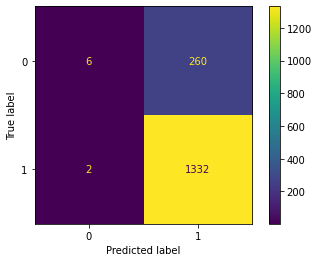

In [26]:
plot_confusion_matrix(classifier, X_val, y_val)
plt.show()

In [27]:
print(classification_report(y_val, y_val_preds, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.75      0.02      0.04       266
           1       0.84      1.00      0.91      1334

    accuracy                           0.84      1600
   macro avg       0.79      0.51      0.48      1600
weighted avg       0.82      0.84      0.77      1600



According to the auc_score, confusion matrix and the classification report, the model is with 0.84 precision, 1.00 recall, 0.84 accuracy and 0.91 f1-score, also given the accuracy and auc score are higher in validation set than in train set. It can be conclude that the predicting power of this model is considerably stronger.

##### **[3.3]** Save to csv

In [32]:
predict = classifier.predict_proba(X_test)[:,1]
test = pd.read_csv('../data/raw/test.csv')
result = pd.DataFrame(data = {'Id': test.loc[:,'Id'], 'TARGET_5Yrs': predict})
result.to_csv("../data/external/wenying_LR_94cols_grids.csv", index = False)